In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch

# Load the metadata
metadata = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')

# Define the directory where images are stored
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'

# Subset the data: take 4000 target0 instances and all target1 instances
target1_data = metadata[metadata['target'] == 1]  # all target1 instances
target0_data = metadata[metadata['target'] == 0].sample(4000)  # subset of 4000 target0

# Ensure exactly 200 class 0 (target0) and 194 class 1 (target1) in the test set
test_target0 = target0_data.sample(200)  # 200 instances of target0
test_target1 = target1_data.sample(194)  # 194 instances of target1

# The remaining data goes to the training set
train_target0 = target0_data.drop(test_target0.index)  # Remaining target0 instances for training
train_target1 = target1_data.drop(test_target1.index)  # Remaining target1 instances for training

# Combine to create the final training and testing datasets
train_df = pd.concat([train_target0, train_target1]).sample(frac=1).reset_index(drop=True)
test_df = pd.concat([test_target0, test_target1]).sample(frac=1).reset_index(drop=True)

# Custom dataset class
class CancerDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        isic_id = self.dataframe.iloc[idx]['isic_id']  # Get the isic_id
        img_name = isic_id + '.jpg'  # Assuming images are in .jpg format
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)
        label = torch.tensor(self.dataframe.iloc[idx]['target'])  # Get the target label

        if self.transform:
            image = self.transform(image)

        return image, label, isic_id  # Now returning isic_id as well

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create the datasets and data loaders
train_dataset = CancerDataset(train_df, image_dir=image_dir, transform=transform)
test_dataset = CancerDataset(test_df, image_dir=image_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


/tmp/ipykernel_23/1192165169.py:10: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv('/kaggle/input/isic-2024-challenge/train-metadata.csv')


In [3]:
import torch.nn as nn
import torchvision.models as models

# Load a pre-trained VGG model
vgg = models.vgg16(pretrained=True)

# Modify the classifier for binary classification
vgg.classifier[6] = nn.Linear(4096, 2)  # 2 classes: cancerous and non-cancerous

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 180MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
class CILoss(nn.Module):
    def __init__(self, Nmax, class_counts, k=1.0, theta=0.5):
        super(CILoss, self).__init__()
        self.Nmax = torch.tensor(Nmax, dtype=torch.float32).to(device)  # Move to device (GPU or CPU)
        self.class_counts = torch.tensor(class_counts, dtype=torch.float32).to(device)  # Move to device
        self.k = k
        self.theta = theta

    def forward(self, outputs, targets):
        # Calculate softmax probabilities
        probs = torch.softmax(outputs, dim=1)  # Probabilities for each class

        # Get the predicted probability for the correct class for each instance
        target_probs = probs[range(len(targets)), targets]
        
        # Dynamically get Nj based on the target class for each instance
        Nj = self.class_counts[targets]  # Ensure class_counts is on the same device as targets
        
        # Class size weight factor (log(Nmax / Nj) + theta)
        class_weights = (torch.log(self.Nmax / Nj) + self.theta)
        
        # Exponential weighting term (e^{-k * target_probs})
        weighted_loss = -class_weights * torch.exp(-self.k * target_probs) * torch.log(target_probs)
        
        # Return the mean loss over the batch
        return weighted_loss.mean()


Epoch 1, Loss: 0.006940425411108942, Accuracy: 90.97274318579645%
Epoch 2, Loss: 0.0060555756596974595, Accuracy: 92.87321830457614%
Epoch 3, Loss: 0.0054579336102097056, Accuracy: 91.79794948737184%
Epoch 4, Loss: 0.004752102751162804, Accuracy: 93.07326831707927%
Epoch 5, Loss: 0.004270973159584829, Accuracy: 93.07326831707927%
Epoch 6, Loss: 0.0035938212634526543, Accuracy: 94.24856214053513%
Epoch 7, Loss: 0.003292464172580773, Accuracy: 94.74868717179295%
Epoch 8, Loss: 0.0024456611132772305, Accuracy: 95.9489872468117%
Epoch 9, Loss: 0.002344649856354437, Accuracy: 95.9489872468117%
Epoch 10, Loss: 0.001701273945856315, Accuracy: 97.22430607651913%
Test Accuracy: 70.81218274111676%
CSV files for misclassified and correctly classified instances saved.


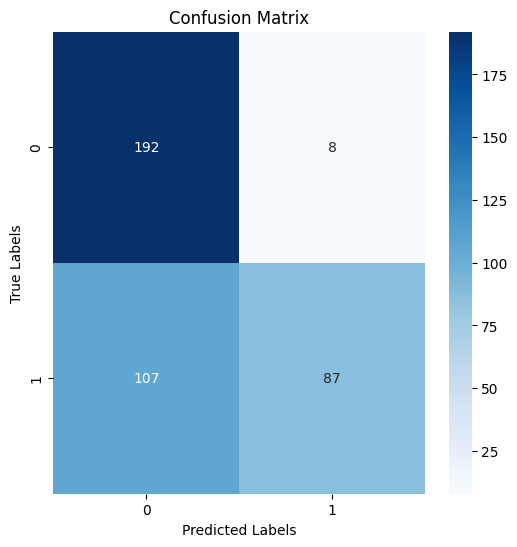

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.64      0.96      0.77       200
     Class 1       0.92      0.45      0.60       194

    accuracy                           0.71       394
   macro avg       0.78      0.70      0.69       394
weighted avg       0.78      0.71      0.69       394



In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.optim as optim  # Importing optim module
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

# Initialize the CI Loss function
Nmax = 4000  # The size of the majority class (target0)
class_counts = [4000, 394]  # Sizes of target0 and target1 classes

# Initialize CI Loss
criterion = CILoss(Nmax=Nmax, class_counts=class_counts, k=1.0, theta=0.5)

# Optimizer (you can adjust the learning rate and other parameters)
optimizer = optim.SGD(vgg.parameters(), lr=0.001, momentum=0.9)

num_epochs = 10

import csv

# Create CSV files for train and test classifications
train_results = {'id': [], 'Prediction': [], 'Ground Truth': [], 'Type': []}
test_results = {'id': [], 'Prediction': [], 'Ground Truth': [], 'Type': []}

# Helper function to classify misclassifications and correct classifications
def classify_predictions(preds, labels, isic_ids, results):
    for pred, label, isic_id in zip(preds, labels, isic_ids):
        if pred == label:
            if label == 1:
                results['Type'].append('True Positive')
            else:
                results['Type'].append('True Negative')
        else:
            if pred == 1:
                results['Type'].append('False Positive')
            else:
                results['Type'].append('False Negative')

        results['id'].append(isic_id)
        results['Prediction'].append(pred.item())
        results['Ground Truth'].append(label.item())

# Training loop
for epoch in range(num_epochs):
    vgg.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels, isic_ids in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Classify and log results for training
        classify_predictions(predicted, labels, isic_ids, train_results)

    print(f'Epoch {epoch+1}, Loss: {running_loss/total}, Accuracy: {100.*correct/total}%')

# Testing loop
vgg.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels, isic_ids in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg(inputs)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Classify and log results for testing
        classify_predictions(predicted, labels, isic_ids, test_results)

        # Collect all labels and predictions for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    print(f'Test Accuracy: {100.*correct/total}%')

# Save train results to CSV
train_df = pd.DataFrame(train_results)
train_df.to_csv('/kaggle/working/train_classifications.csv', index=False)

# Save test results to CSV
test_df = pd.DataFrame(test_results)
test_df.to_csv('/kaggle/working/test_classifications.csv', index=False)

print("CSV files for misclassified and correctly classified instances saved.")

# Calculate and display confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.006384783175944626, Accuracy: 94.69867466866717%
Epoch 2, Loss: 0.005049420305008171, Accuracy: 95.22380595148788%
Epoch 3, Loss: 0.004445689470908006, Accuracy: 95.64891222805701%
Epoch 4, Loss: 0.004097129118603881, Accuracy: 95.74893723430857%
Epoch 5, Loss: 0.003541026518743734, Accuracy: 96.42410602650662%
Epoch 6, Loss: 0.003071872385360336, Accuracy: 96.64916229057265%
Epoch 7, Loss: 0.0026732419302375444, Accuracy: 97.12428107026757%
Epoch 8, Loss: 0.002020147879787067, Accuracy: 97.72443110777695%
Epoch 9, Loss: 0.0016722760925842177, Accuracy: 98.12453113278319%
Epoch 10, Loss: 0.0015823101441388254, Accuracy: 98.34958739684922%
Test Accuracy: 66.49746192893402%
CSV files for misclassified and correctly classified instances saved.


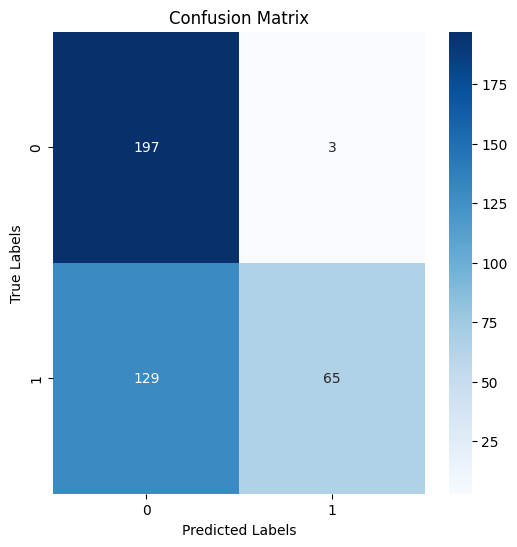

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.60      0.98      0.75       200
     Class 1       0.96      0.34      0.50       194

    accuracy                           0.66       394
   macro avg       0.78      0.66      0.62       394
weighted avg       0.78      0.66      0.62       394



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report
from torchvision import models
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the pre-trained VGG model
vgg_binar = models.vgg16(pretrained=True)

# Modify the last layer for binary classification (2 classes: cancerous and non-cancerous)
vgg_binar.classifier[6] = nn.Linear(4096, 2)  # Output layer: 2 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_binar = vgg_binar.to(device)

# Define the standard binary cross-entropy loss
criterion = nn.CrossEntropyLoss()

# Optimizer (you can adjust the learning rate and other parameters)
optimizer = optim.SGD(vgg_binar.parameters(), lr=0.001, momentum=0.9)

import csv

# Create CSV files for train and test classifications
train_results = {'id': [], 'Prediction': [], 'Ground Truth': [], 'Type': []}
test_results = {'id': [], 'Prediction': [], 'Ground Truth': [], 'Type': []}

# Helper function to classify misclassifications and correct classifications
def classify_predictions(preds, labels, isic_ids, results):
    for pred, label, isic_id in zip(preds, labels, isic_ids):
        if pred == label:
            if label == 1:
                results['Type'].append('True Positive')
            else:
                results['Type'].append('True Negative')
        else:
            if pred == 1:
                results['Type'].append('False Positive')
            else:
                results['Type'].append('False Negative')

        results['id'].append(isic_id)
        results['Prediction'].append(pred.item())
        results['Ground Truth'].append(label.item())

# Training loop for vgg_binor
for epoch in range(num_epochs):
    vgg_binar.train()  # Changed to vgg_binor
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels, isic_ids in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg_binar(inputs)  # Changed to vgg_binor
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Classify and log results for training
        classify_predictions(predicted, labels, isic_ids, train_results)

    print(f'Epoch {epoch+1}, Loss: {running_loss/total}, Accuracy: {100.*correct/total}%')

# Testing loop for vgg_binor
# Testing loop
vgg_binar.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels, isic_ids in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg_binar(inputs)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Classify and log results for testing
        classify_predictions(predicted, labels, isic_ids, test_results)

        # Collect all labels and predictions for the confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    print(f'Test Accuracy: {100.*correct/total}%')

# Save train results to CSV
train_df = pd.DataFrame(train_results)
train_df.to_csv('/kaggle/working/train_classifications.csv', index=False)

# Save test results to CSV
test_df = pd.DataFrame(test_results)
test_df.to_csv('/kaggle/working/test_classifications.csv', index=False)

print("CSV files for misclassified and correctly classified instances saved.")

# Calculate and display confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1']))

In [7]:

!zip -r train_custom_output.zip train_custom_output
!zip -r test_custom_output.zip test_custom_output
!zip -r test_binar_output.zip test_binar_output
from IPython.display import FileLink


FileLink('train_custom_output.zip')
FileLink('test_custom_output.zip')
FileLink('test_binar_output.zip')

	zip warning: name not matched: train_custom_output

zip error: Nothing to do! (try: zip -r train_custom_output.zip . -i train_custom_output)
	zip warning: name not matched: test_custom_output

zip error: Nothing to do! (try: zip -r test_custom_output.zip . -i test_custom_output)
	zip warning: name not matched: test_binar_output

zip error: Nothing to do! (try: zip -r test_binar_output.zip . -i test_binar_output)


/kaggle/working/test_binar_output.zip

In [8]:
import csv

# Create CSV files for train and test classifications
train_results = {'id': [], 'Prediction': [], 'Ground Truth': [], 'Type': []}
test_results = {'id': [], 'Prediction': [], 'Ground Truth': [], 'Type': []}

# Helper function to classify misclassifications and correct classifications
def classify_predictions(preds, labels, isic_ids, results):
    for pred, label, isic_id in zip(preds, labels, isic_ids):
        if pred == label:
            if label == 1:
                results['Type'].append('True Positive')
            else:
                results['Type'].append('True Negative')
        else:
            if pred == 1:
                results['Type'].append('False Positive')
            else:
                results['Type'].append('False Negative')

        results['id'].append(isic_id)
        results['Prediction'].append(pred.item())
        results['Ground Truth'].append(label.item())

# Training loop
for epoch in range(num_epochs):
    vgg.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels, isic_ids in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = vgg(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Classify and log results for training
        classify_predictions(predicted, labels, isic_ids, train_results)

    print(f'Epoch {epoch+1}, Loss: {running_loss/total}, Accuracy: {100.*correct/total}%')

# Testing loop
vgg.eval()
with torch.no_grad():
    correct = 0
    total = 0

    for inputs, labels, isic_ids in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg(inputs)
        _, predicted = outputs.max(1)

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Classify and log results for testing
        classify_predictions(predicted, labels, isic_ids, test_results)

    print(f'Test Accuracy: {100.*correct/total}%')

# Save train results to CSV
train_df = pd.DataFrame(train_results)
train_df.to_csv('/kaggle/working/train_classifications.csv', index=False)

# Save test results to CSV
test_df = pd.DataFrame(test_results)
test_df.to_csv('/kaggle/working/test_classifications.csv', index=False)

print("CSV files for misclassified and correctly classified instances saved.")


Epoch 1, Loss: 0.0019712259403282507, Accuracy: 98.59964991247811%
Epoch 2, Loss: 0.002042308925304242, Accuracy: 98.49962490622656%
Epoch 3, Loss: 0.0020228340047117946, Accuracy: 98.42460615153789%
Epoch 4, Loss: 0.0019991649522032254, Accuracy: 98.29957489372343%
Epoch 5, Loss: 0.002005798928719084, Accuracy: 98.44961240310077%
Epoch 6, Loss: 0.002014812252526881, Accuracy: 98.3745936484121%
Epoch 7, Loss: 0.0019451586935304945, Accuracy: 98.49962490622656%
Epoch 8, Loss: 0.002038774059847403, Accuracy: 98.49962490622656%
Epoch 9, Loss: 0.0020131822239964356, Accuracy: 98.52463115778944%
Epoch 10, Loss: 0.002063772848160543, Accuracy: 98.34958739684922%
Test Accuracy: 70.81218274111676%
CSV files for misclassified and correctly classified instances saved.


In [9]:
import os
import pandas as pd
import shutil

# Define directories for images based on prediction type
output_dir = '/kaggle/working/test_VGG(CI)_images'
os.makedirs(output_dir, exist_ok=True)

prediction_types = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
for pred_type in prediction_types:
    os.makedirs(os.path.join(output_dir, pred_type), exist_ok=True)

# Load the test classification results
test_df = pd.read_csv('/kaggle/working/test_classifications.csv')

# Define the image directory
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'

# Function to copy images based on prediction type
def copy_images_by_prediction(test_df, image_dir, output_dir):
    for _, row in test_df.iterrows():
        isic_id = row['id']
        pred_type = row['Type']
        
        # Construct image path
        img_name = f"{isic_id}.jpg"
        img_path = os.path.join(image_dir, img_name)
        
        # Check if the image exists
        if os.path.exists(img_path):
            target_dir = os.path.join(output_dir, pred_type)
            shutil.copy(img_path, os.path.join(target_dir, img_name))

# Call the function to copy images
copy_images_by_prediction(test_df, image_dir, output_dir)

print("Images organized by prediction type successfully.")


Images organized by prediction type successfully.


In [10]:
from IPython.display import FileLink

# Create the zip file
!zip -r "test_VGG(CI)_images.zip" "test_VGG(CI)_images"

# Create a link to download the zip file
FileLink("test_VGG(CI)_images.zip")


  adding: test_VGG(CI)_images/ (stored 0%)
  adding: test_VGG(CI)_images/False Negative/ (stored 0%)
  adding: test_VGG(CI)_images/False Negative/ISIC_0445144.jpg (deflated 5%)
  adding: test_VGG(CI)_images/False Negative/ISIC_3005303.jpg (deflated 4%)
  adding: test_VGG(CI)_images/False Negative/ISIC_2235682.jpg (deflated 6%)
  adding: test_VGG(CI)_images/False Negative/ISIC_1071492.jpg (deflated 4%)
  adding: test_VGG(CI)_images/False Negative/ISIC_3190920.jpg (deflated 8%)
  adding: test_VGG(CI)_images/False Negative/ISIC_4614975.jpg (deflated 5%)
  adding: test_VGG(CI)_images/False Negative/ISIC_1621074.jpg (deflated 5%)
  adding: test_VGG(CI)_images/False Negative/ISIC_3377793.jpg (deflated 7%)
  adding: test_VGG(CI)_images/False Negative/ISIC_5225958.jpg (deflated 4%)
  adding: test_VGG(CI)_images/False Negative/ISIC_4114301.jpg (deflated 6%)
  adding: test_VGG(CI)_images/False Negative/ISIC_8110460.jpg (deflated 5%)
  adding: test_VGG(CI)_images/False Negative/ISIC_6246414.jpg (

/kaggle/working/test_VGG(CI)_images.zip

In [11]:
import os
import pandas as pd
import shutil

# Define directories for images based on prediction type
output_dir = '/kaggle/working/test_VGG(binar)_images'
os.makedirs(output_dir, exist_ok=True)

prediction_types = ['True Positive', 'True Negative', 'False Positive', 'False Negative']
for pred_type in prediction_types:
    os.makedirs(os.path.join(output_dir, pred_type), exist_ok=True)

# Load the test classification results
test_df = pd.read_csv('/kaggle/input/cooooochie/test_classifications_vgg_binary.csv')

# Define the image directory
image_dir = '/kaggle/input/isic-2024-challenge/train-image/image'

# Function to copy images based on prediction type
def copy_images_by_prediction(test_df, image_dir, output_dir):
    for _, row in test_df.iterrows():
        isic_id = row['id']
        pred_type = row['Type']
        
        # Construct image path
        img_name = f"{isic_id}.jpg"
        img_path = os.path.join(image_dir, img_name)
        
        # Check if the image exists
        if os.path.exists(img_path):
            target_dir = os.path.join(output_dir, pred_type)
            shutil.copy(img_path, os.path.join(target_dir, img_name))

# Call the function to copy images
copy_images_by_prediction(test_df, image_dir, output_dir)

print("Images organized by prediction type successfully.")


Images organized by prediction type successfully.


In [12]:
from IPython.display import FileLink

# Create the zip file
!zip -r "test_VGG(binar)_images.zip" "test_VGG(binar)_images"

# Create a link to download the zip file
FileLink("test_VGG(binar)_images.zip")


  adding: test_VGG(binar)_images/ (stored 0%)
  adding: test_VGG(binar)_images/False Negative/ (stored 0%)
  adding: test_VGG(binar)_images/False Negative/ISIC_0445144.jpg (deflated 5%)
  adding: test_VGG(binar)_images/False Negative/ISIC_3481735.jpg (deflated 5%)
  adding: test_VGG(binar)_images/False Negative/ISIC_1186361.jpg (deflated 7%)
  adding: test_VGG(binar)_images/False Negative/ISIC_4614975.jpg (deflated 5%)
  adding: test_VGG(binar)_images/False Negative/ISIC_1621074.jpg (deflated 5%)
  adding: test_VGG(binar)_images/False Negative/ISIC_1935982.jpg (deflated 6%)
  adding: test_VGG(binar)_images/False Negative/ISIC_4907011.jpg (deflated 6%)
  adding: test_VGG(binar)_images/False Negative/ISIC_3377793.jpg (deflated 7%)
  adding: test_VGG(binar)_images/False Negative/ISIC_9855202.jpg (deflated 4%)
  adding: test_VGG(binar)_images/False Negative/ISIC_3813551.jpg (deflated 6%)
  adding: test_VGG(binar)_images/False Negative/ISIC_5643847.jpg (deflated 5%)
  adding: test_VGG(binar

/kaggle/working/test_VGG(binar)_images.zip